# 数据科学大作业
* 小组成员:杨熙承，王语桐，郑涵，应嘉铭
* 选题:`6`.草体汉字数据集
* 老师:叶鸿
```
汉代初期，书写隶书时有时才“草率”地书写而形成的，也称为“章草”，是一种隶书草书。章草字字独立，接近于行草，但对难写之字简化不多，书写不变。后来楷书出现，又演变成“今草”，即楷书草书，写字迅速，往往上下字连写，末笔与起笔相呼应，每个字一般也有简化的规律，但不太熟悉的人有时不易辨认。一般也把王羲之、王献之等人的草书称为今草。
草体汉字对非专业人士来说，难以辨认。因此，如何得到一个实用模型来辅助艺术鉴赏，就是一件十分有趣的事。
```

## 大作业设计思路
1. 数据收集:因为老师已经提供了数据集，无需自行查找🤪
2. 数据预处理:图片进行标准化处理🤔
3. 特征提取:卷积神经网络`（CNN）`来提取草书和楷书的特征🤩 
4. 模型训练:使用深度学习模型进行训练🤩 
5. 模型测试和验证:测试集数据来评估模型的准确性和可靠性🤩 
6. 应用:将训练好的模型应用于草书字体辨识🥳🥳🥳🥳🥳🥳🥳

## 数据预处理
### 数据压缩包解压至当前文件夹，命名为`data`
### 问题🤢(参考了部分博客和文献)
1. 图像不够清晰
2. 中文乱码

In [1]:
## 高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
## 显示中文的问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns 
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)

### 导入需要的库(比较多🤮)

#### 打开cmd安装需要的python库
```
pip install numpy pandas matplotlib pillow scikit-learn torch torchvision
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam
import torch.utils.data as Data
from torchvision import models
from torchvision import transforms
import time

### 设计友好的可视化界面🤔
可以易于读者了解

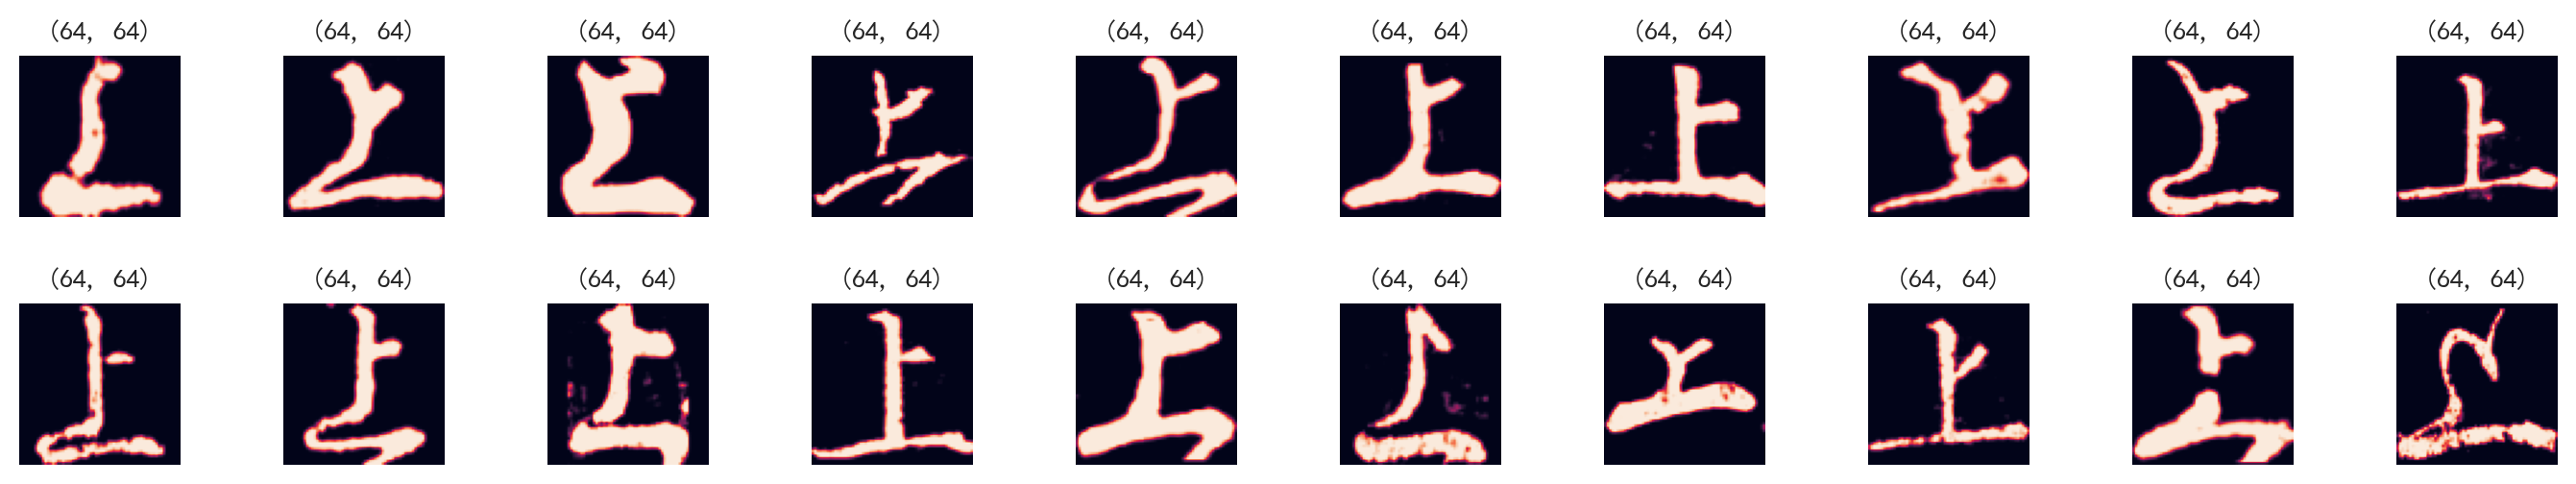

In [3]:
## 先来一个文字进行处理
filename = "data\\U+4E0A"
imagename = os.listdir(filename)
## 读取图像
plt.figure(figsize = (14,8))
for ii,imname in zip(range(20),imagename):
    plt.subplot(6,10,ii+1)
    img = Image.open(filename + "/" + imname)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img.size,size = 10)
plt.tight_layout()
plt.show()


#### 统一尺寸大小，并转化为灰度图像(这一步好像很重要🤯🤯🤯)

In [4]:
## 定义一个对单张图像进行处理的操作
def SingleImageProcess(im):
    width,high = im.size
    im = im.convert("L")  ## 转化为灰度图像
    ## 尺寸转化为128*128
    im = im.resize((128,128), Image.ANTIALIAS)
    return im

#### 在进行一次可视化，可视处理好的图片🥴

C:\Users\Naasi\AppData\Local\Temp\ipykernel_12212\3520757745.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((128,128), Image.ANTIALIAS)


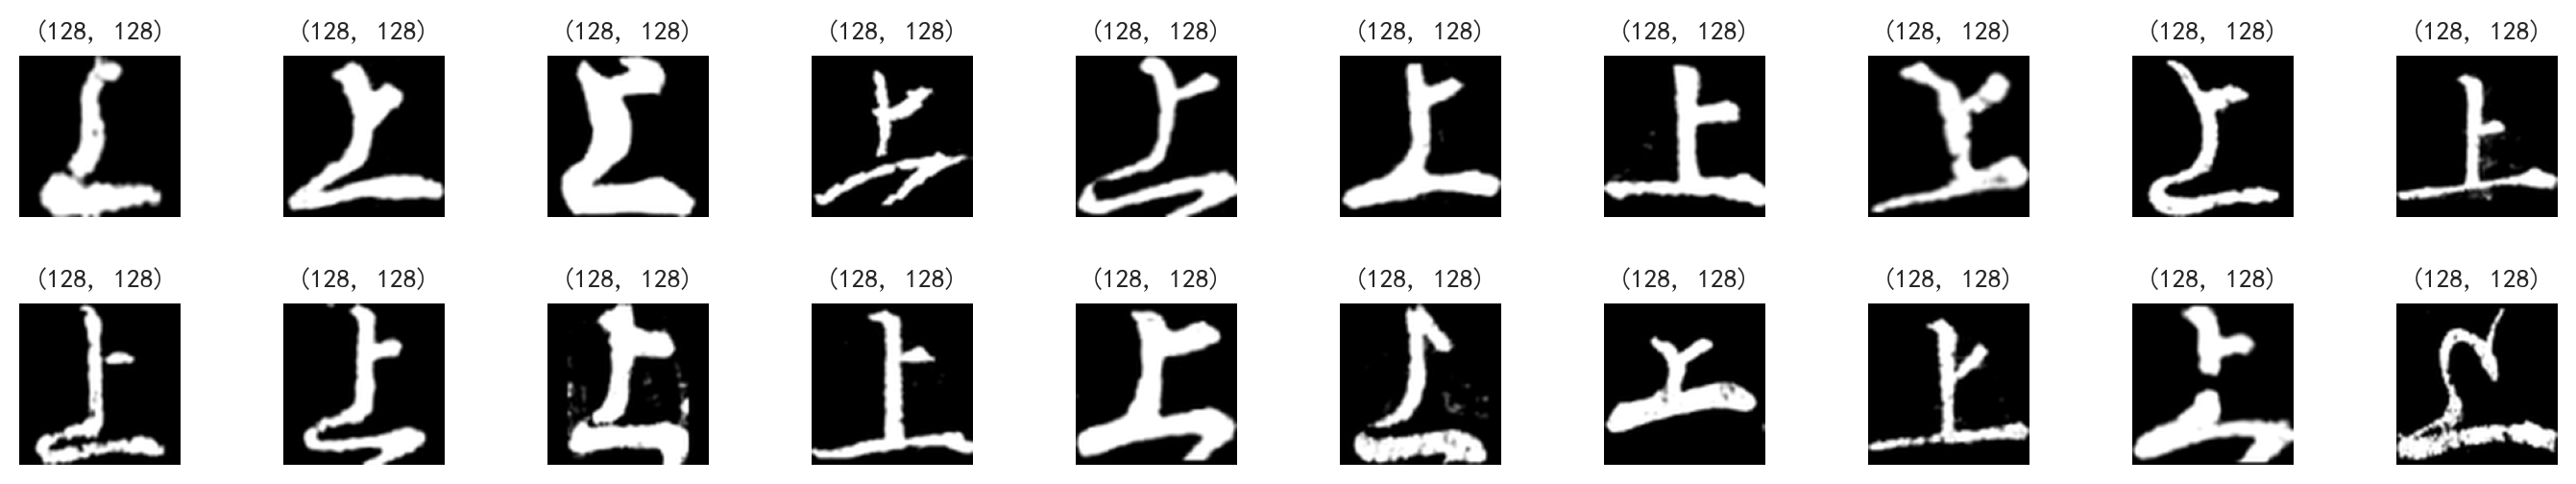

In [5]:
## 读取所有的图像,并可视化出其中的60张图像
plt.figure(figsize = (14,8))
for ii,imname in zip(range(20),imagename):
    plt.subplot(6,10,ii+1)
    img = Image.open(filename + "/" + imname)
    img = SingleImageProcess(img)
    plt.imshow(img,cmap = plt.cm.gray)
    plt.axis("off")
    plt.title(img.size,size = 10)
plt.tight_layout()
plt.show()

##### tips: 刚刚只是单个文字的处理，不过单个肯定是不够，模型需要很大的数据集才行🤗

#### 定义一个读取单个文件夹图像的程序
#### 定义一个读取所有子文件夹图像的函数
##### tips:数据集过大导致占用电脑过大内存问题，因此**缩小了数据集范围**

In [6]:
import random

## 读取单个文件
def readimages(filedir,filename):
    filealldir = filedir + "/" + filename
    imfiles = os.listdir(filealldir)   # 索取所有的图像文件名称
    ## 过滤掉隐藏文件
    imfiles = [imf for imf  in imfiles if not imf.startswith('.')]
    imnum = len(imfiles)        # 图像的数量
    imgs = []     # 图像保存为列表
    imlab = [filename] *  imnum    # 图像的标签
    ## 读取图像
    for name in imfiles:
        imdir = filealldir + "/" + name
        img = Image.open(imdir)
        ## 对每张图像进行预处理
        img = SingleImageProcess(img)
        imgs.append(np.array(img))
    return imgs,np.array(imlab)

## 读取所有子文件，但是我只能读取前面40%
## 定义一个读取所有子文件夹图像的函数
def readallimages(filedir):
    imagename = os.listdir(filedir)
    ## 过滤掉隐藏文件
    imagename = [imf for imf  in imagename if not imf.startswith('.')]
    imgs = []  # 使用列表保存所有图像数据
    labs = []  # 使用列表保存所有图像标签
    ## 读取单个文件夹的数据
    for filename in imagename:
        onefileimages, onefilelabs = readimages(filedir,filename)
        imgs.append(onefileimages)   # 数组拼接
        labs.append(onefilelabs)
    return imgs,labs

#### 读取部分数据
##### 问题:数据过大占用过多内存导致系统崩溃
##### 解决方法
回到上面的`readallimages`代码,进行修改

In [7]:
## 调用所定义的函数，读取所有数据
filename = "data"
allfileimages, allfilelabs = readallimages(filename)
## 数据转化为数组
allfileimages = np.concatenate(allfileimages)
allfilelabs = np.concatenate(allfilelabs,axis = 0)
print(allfileimages.shape)
print(allfilelabs.shape)

C:\Users\Naasi\AppData\Local\Temp\ipykernel_12212\3520757745.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((128,128), Image.ANTIALIAS)


(57979, 128, 128)
(57979,)


#### 保存数据集
到这一步**数据预处理**就完成了

In [8]:
# ## 将读取的数据进行保存，
np.savez("草书数据集.npz",
         x = allfileimages,y = allfilelabs)

#### 随机查看数据集(抽样查看)
这里如果抽样太多电脑会崩溃，所以只抽样了20条🤢

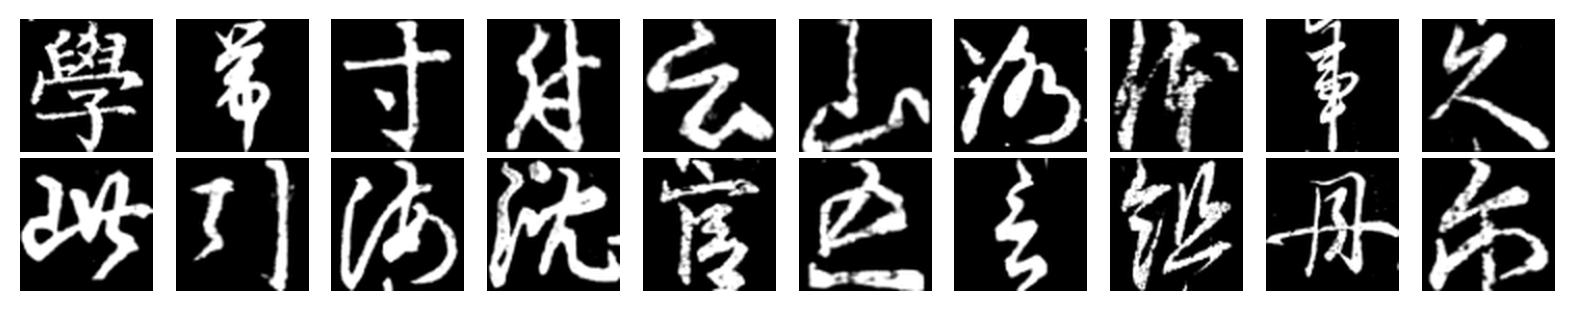

In [9]:
## 对标签进编码
LE = LabelEncoder().fit(allfilelabs)
imagelab =LE.transform(allfilelabs)

## 可视化其中的部分图像用于查看
imagex = allfileimages / 225.0

## 随机选择一些样本进行可视化
np.random.seed(123)
index = np.random.permutation(len(imagelab))[0:20]
plt.figure(figsize = (10,9))
for ii,ind in enumerate(index):
    plt.subplot(10,10,ii+1)
    img = imagex[ind,...]
    plt.imshow(img,cmap = plt.cm.gray)
    plt.axis("off")
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()


### 特征提取和模型训练😎

#### 数据分类(训练集和测试集)

In [10]:
## 数据切分为训练集和测试集
X_train_im,X_test_im,y_train_im,y_test_im = train_test_split(
    imagex,imagelab,test_size = 0.25,random_state = 2)

## 将数据转化为Pytorch可以使用的张量
train_xt = torch.from_numpy(X_train_im.astype(np.float32)) 
train_xt = train_xt.unsqueeze(1)     # 添加一个颜色通道
train_yt = torch.from_numpy(y_train_im.astype(np.int64))
test_xt = torch.from_numpy(X_test_im.astype(np.float32))
test_xt = test_xt.unsqueeze(1)
test_yt = torch.from_numpy(y_test_im.astype(np.int64))
print(train_xt.shape)
print(train_yt.shape)
print(test_xt.shape)
print(test_yt.shape)

torch.Size([43484, 1, 128, 128])
torch.Size([43484])
torch.Size([14495, 1, 128, 128])
torch.Size([14495])


#### 构建训练加载器和数据加载器

In [11]:
## 构建数据加载器
BATCH_SIZE = 64    # 每个Batch使用的图像数量
## 定义一个训练数据加载器
train_data = Data.TensorDataset(train_xt,train_yt)
train_loader = Data.DataLoader(
    dataset = train_data,    ## 使用的数据集
    batch_size=BATCH_SIZE,   ##  批处理样本大小
    shuffle = True,          ## 每次迭代前打乱数据
    num_workers = 0,         
)

## 定义一个测试数据加载器
test_data = Data.TensorDataset(test_xt,test_yt)
test_loader = Data.DataLoader(
    dataset = test_data,      ## 使用的数据集
    batch_size=BATCH_SIZE,    ## 批处理样本大小
    shuffle = False,          ## 每次迭代前不打乱数据
    num_workers = 0,          
)

## 查看一个batch的图像的尺寸
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 128, 128])
torch.Size([64])


#### 查看标签

#### 卷积神经网络(核心代码🤫)

##### 判断类别数(调整全连接层需要总类别数)

查看数据集的键值

In [28]:
import numpy as np

data = np.load("草书数据集.npz")
print(data.files)


['x', 'y']


查看总类别

In [29]:
import numpy as np

# 读取数据集文件
Data = np.load("草书数据集.npz", allow_pickle=True)
# 查看数据集中的标签
labelss = Data["y"]
# 统计标签中不同类别的数量
num_classes = len(np.unique(labelss))
print("数据集中的类别数为：", num_classes)


数据集中的类别数为： 1352


In [30]:
## 导入ResNet18
resnet18 = models.resnet18(pretrained=True)
## 微调resnet18获得适合我们数据集的网络
## 调整第一个输入卷积层
resnet18.conv1 = nn.Conv2d(1, 64,kernel_size=(7, 7),
                           stride=(2, 2), padding=(3, 3))
## 调整全连接层
resnet18.fc = nn.Sequential(nn.Linear(512,1352),nn.Softmax(dim = 1))
resnet18

C:\Users\Naasi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Naasi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

#### 定义网络的训练过程函数

In [31]:
## 定义网络的训练过程函数
def train_CNNNet(model,traindataloader, testdataloader,criterion, optimizer,
                 num_epochs=25):
    """
    model:网络模型；traindataloader:训练数据集
    testdataload:测试数据集，;criterion：损失函数；optimizer：优化方法；
    num_epochs:训练的轮数
    """
    ## 保存训练和测试过程中的损失和预测精度
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # 每个epoch有两个阶段,训练阶段和测试阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        test_loss = 0.0
        test_corrects = 0
        test_num = 0
        model.train() ## 设置模型为训练模式
        for step,(b_x,b_y) in enumerate(traindataloader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            output = model(b_x)     
            pre_lab = torch.argmax(output,1)
            loss = criterion(output, b_y)  # 计算损失
            optimizer.zero_grad()          # 梯度归零
            loss.backward()                # 损失后项传播
            optimizer.step()               # 优化参数
            train_loss += loss.item() * b_x.size(0)
            train_corrects += torch.sum(pre_lab == b_y.data)
            train_num += b_x.size(0)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        
        ## 计算一个epoch的训练后在测试集上的损失和精度
        model.eval() ## 设置模型为训练模式评估模式 
        for step,(b_x,b_y) in enumerate(testdataloader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            output = model(b_x)     
            pre_lab = torch.argmax(output,1)
            loss = criterion(output, b_y) 
            test_loss += loss.item() * b_x.size(0)
            test_corrects += torch.sum(pre_lab == b_y.data)
            test_num += b_x.size(0)
        ## 计算一个epoch在测试集上的损失和精度
        test_loss_all.append(test_loss / test_num)
        test_acc_all.append(test_corrects.double().item()/test_num)
        print('{} Test Loss: {:.4f}  Test Acc: {:.4f}'.format(
            epoch, test_loss_all[-1], test_acc_all[-1]))
    ## 输出相关训练过程的数值
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "train_acc_all":train_acc_all,
              "test_loss_all":test_loss_all,
              "test_acc_all":test_acc_all})
    return model,train_process

#### 开始训练🤪🤪🤪(时间很长，我用时600分钟)

In [32]:
## 定义计算设备
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## 训练网络时没经过一定的epoch改变学习率的大小
train_promodel = []  ## 网络训练过程
LR = [0.0005,0.0001]
loss_func = nn.CrossEntropyLoss()   # 交叉熵损失函数
EachEpoch = [20,20]   # 每隔EachEpoch次训练更新一次学习率

## 训练
for ii,lri in enumerate(LR):
    # 定义优化器
    print("======学习率为:",lri,"======")
    optimizer1 = torch.optim.Adam(resnet18.parameters(),lr=lri)   
    resnet18,train_process = train_CNNNet(
        resnet18,train_loader,test_loader,loss_func, 
        optimizer1, num_epochs=EachEpoch[ii])
    ## 保存训练过程
    train_promodel.append(train_process)
## 组合查看训练过程数据表
mytrain_promodel = pd.concat(train_promodel)

======学习率为: 0.0005 ======
----------
Epoch 0/19
0 Train Loss: 6.8998  Train Acc: 0.3154
0 Test Loss: 6.8158  Test Acc: 0.3970
----------
Epoch 1/19
1 Train Loss: 6.7873  Train Acc: 0.4263
1 Test Loss: 6.7467  Test Acc: 0.4663
----------
Epoch 2/19
2 Train Loss: 6.7403  Train Acc: 0.4728
2 Test Loss: 6.7180  Test Acc: 0.4967
----------
Epoch 3/19
3 Train Loss: 6.7101  Train Acc: 0.5026
3 Test Loss: 6.7040  Test Acc: 0.5085
----------
Epoch 4/19
4 Train Loss: 6.6934  Train Acc: 0.5192
4 Test Loss: 6.6871  Test Acc: 0.5254
----------
Epoch 5/19
5 Train Loss: 6.6777  Train Acc: 0.5347
5 Test Loss: 6.6632  Test Acc: 0.5490
----------
Epoch 6/19
6 Train Loss: 6.6566  Train Acc: 0.5558
6 Test Loss: 6.6500  Test Acc: 0.5626
----------
Epoch 7/19
7 Train Loss: 6.6423  Train Acc: 0.5700
7 Test Loss: 6.6412  Test Acc: 0.5711
----------
Epoch 8/19
8 Train Loss: 6.6340  Train Acc: 0.5781
8 Test Loss: 6.6396  Test Acc: 0.5722
----------
Epoch 9/19
9 Train Loss: 6.6252  Train Acc: 0.5868
9 Test Loss:

### 模型验证
利用刚学的`matplotlib`来可视化结果，从而判断模型的可行性🤭

#### 问题:中文的乱码格式
解决办法:已放在文章开头

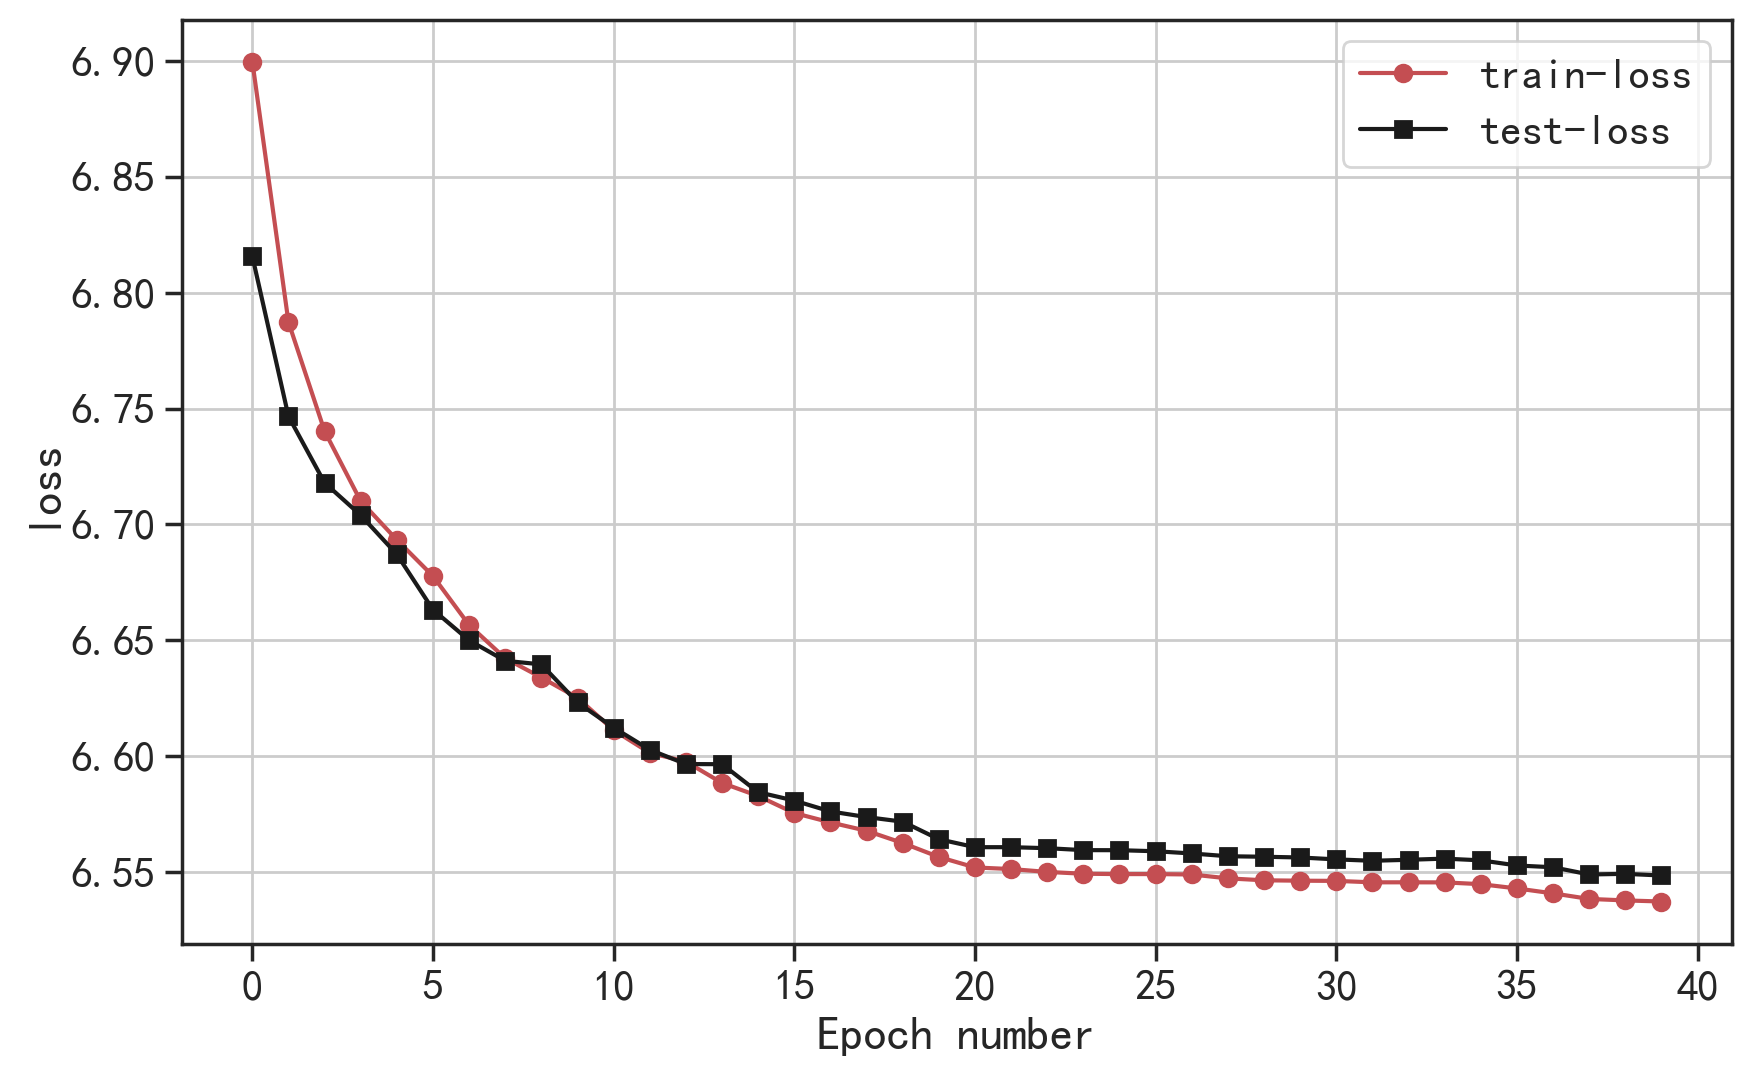

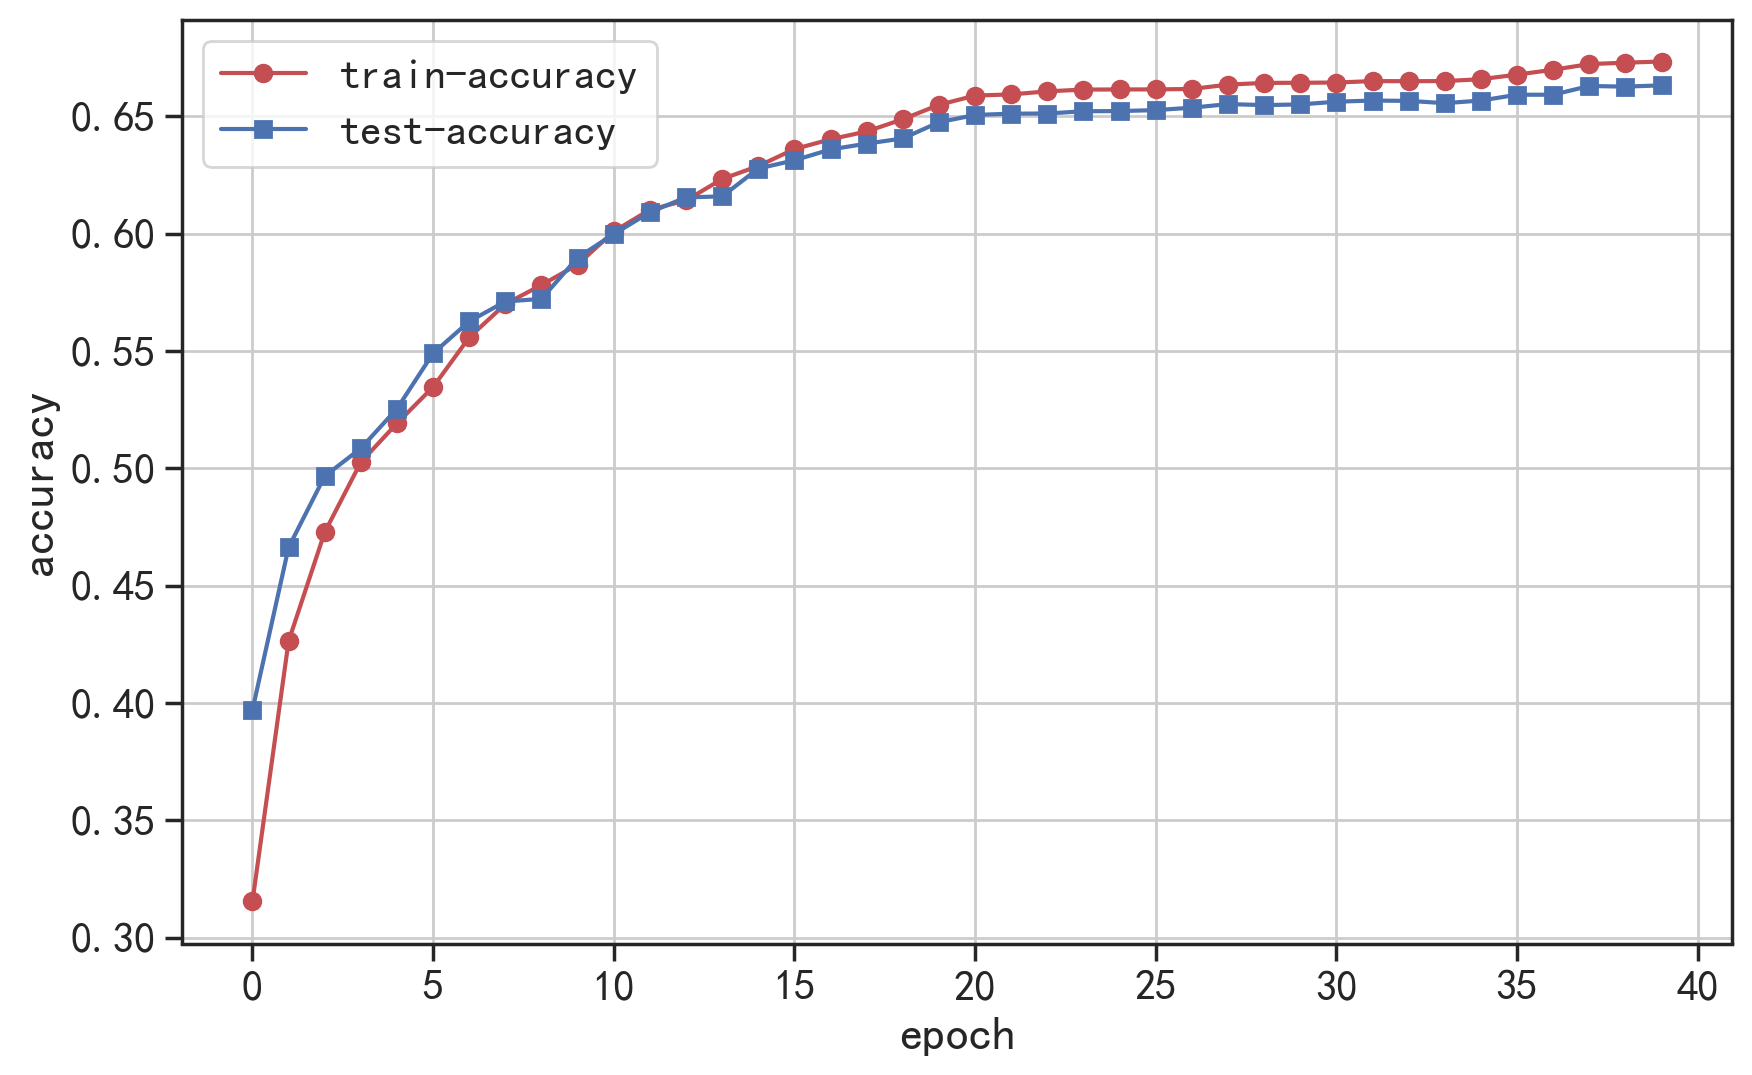

In [34]:
## 可视化训练过程和测试过程的损失函数变化情况
plotlen = mytrain_promodel.shape[0]
plt.figure(figsize=(10,6))
plt.plot(np.arange(plotlen),mytrain_promodel.train_loss_all,
         "r-o",label = "train-loss")
plt.plot(np.arange(plotlen),mytrain_promodel.test_loss_all,
         "k-s",label = "test-loss")
plt.legend()
plt.grid()
plt.xlabel("Epoch number")
plt.ylabel("loss")
plt.show()
## 可视化训练过程和测试过程的预测精度变化情况
plt.figure(figsize=(10,6))
plt.plot(np.arange(plotlen),mytrain_promodel.train_acc_all,
         "r-o",label = "train-accuracy")
plt.plot(np.arange(plotlen),mytrain_promodel.test_acc_all,
         "b-s",label = "test-accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()


#### 展现其他的图标形式

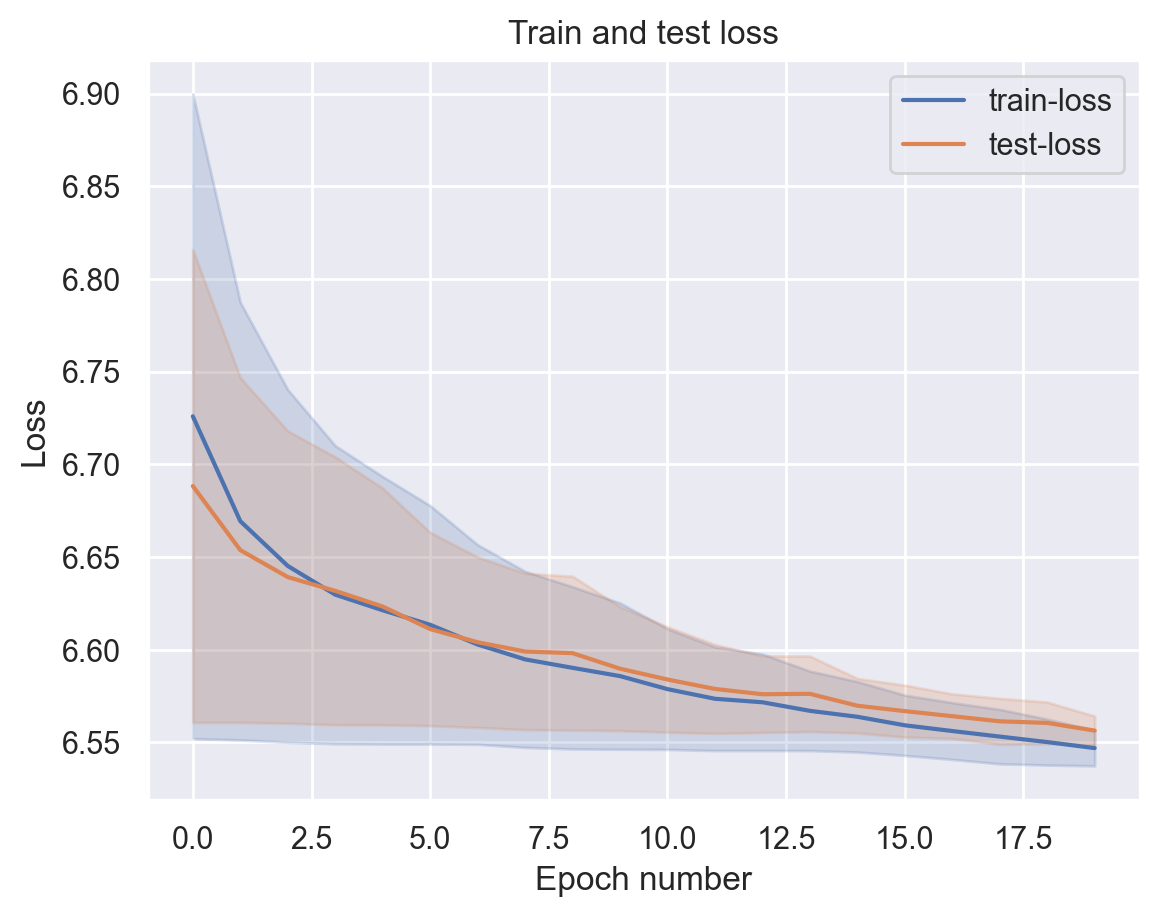

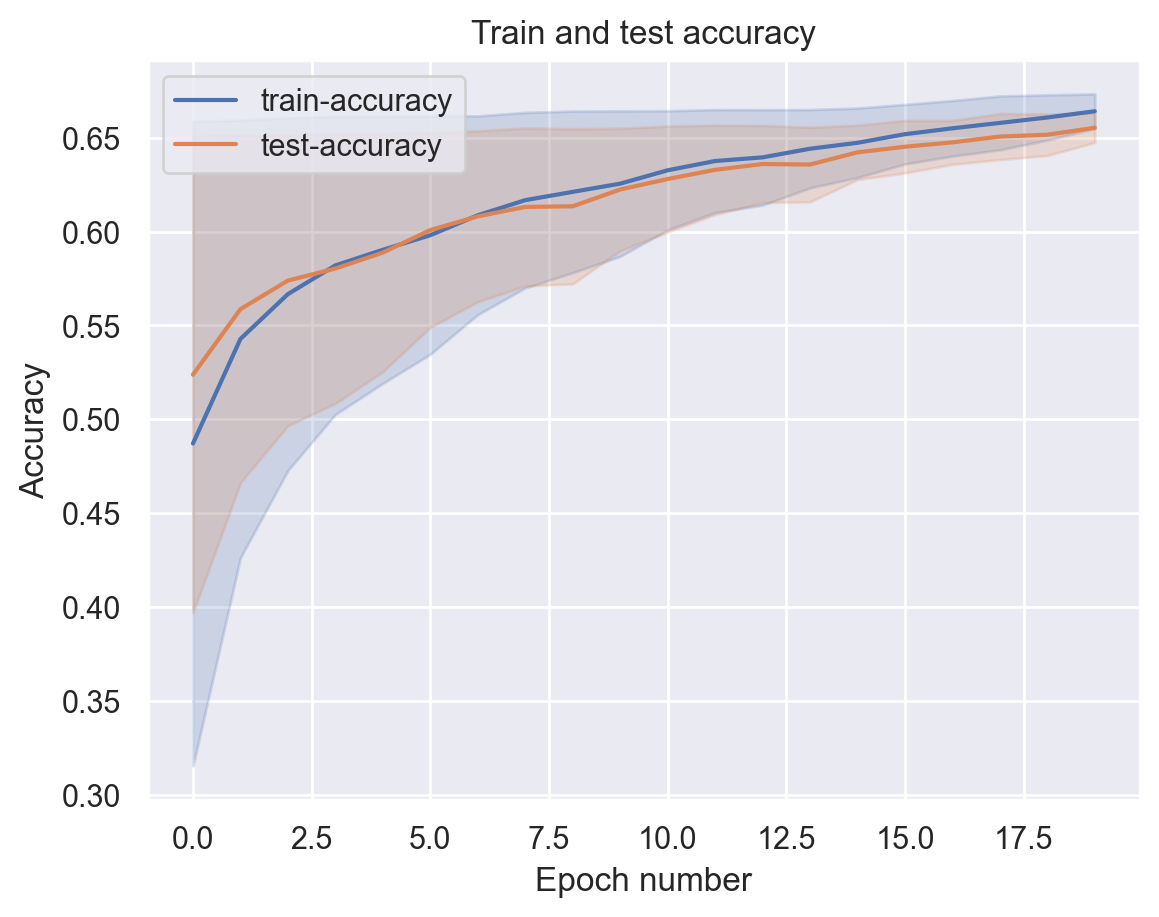

In [35]:
import seaborn as sns

sns.set(style='darkgrid')
sns.lineplot(data=mytrain_promodel.train_loss_all, label='train-loss')
sns.lineplot(data=mytrain_promodel.test_loss_all, label='test-loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Train and test loss')
plt.show()

sns.set(style='darkgrid')
sns.lineplot(data=mytrain_promodel.train_acc_all, label='train-accuracy')
sns.lineplot(data=mytrain_promodel.test_acc_all, label='test-accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy')
plt.show()


### 应用
现在，这个小ai🤖已经具有鉴赏的能力了